# Estimate Canopy Cover and PAVD from ICESat-2 data

This also estimates the canopy and ground reflectance ratio, which is needed for simulation of ICESat-2 following Purslow et al. (2023)

In [13]:
# pip install git+https://github.com/armstonj/gedipy 

In [1]:
import os
import numpy
import warnings
from numba import njit
from pyproj import Transformer
from scipy import stats
from scipy import odr
import matplotlib.pyplot as plt
import ipywidgets
from gedipy import h5io

## Define an ATL03 and ATL08 orbit pair

In [2]:
os.chdir('/gpfs/data1/vclgp/urbazaevm/ATL08/SA/ATL03/')
atl03_filename = 'ATL03_20210126213901_05171014_006_01.h5'
atl08_filename = 'ATL08_20210126213901_05171014_006_01.h5'

## Open the input files

In [3]:
# Open the ATL03 file
atl03_fid = h5io.ATL03H5File(atl03_filename)
atl03_fid.open_h5()

# Open the ATL08 file
atl08_fid = h5io.ATL08H5File(atl08_filename)
atl08_fid.open_h5()

## Select a power beam

In [4]:
# Which beams are power/weak depends on the orientation of the satellite
atlas_orientation = atl03_fid.get_atlas_orientation()
if atlas_orientation == 'backward':
    power_beams = [beam for beam in atl03_fid.beams if beam.endswith('l')]
elif atlas_orientation == 'forward':
    power_beams = [beam for beam in atl03_fid.beams if beam.endswith('r')]
else:
    print('ATLAS orientation in transition, do not use')

# Select the RGT center power beam for this example
beam = next(power_beam for power_beam in power_beams if 'gt2' in power_beam)

# Is it night or day?
night_flag = atl08_fid.get_dataset(beam, 'land_segments/night_flag')
print('{:.2f}% of the land segments are night time'.format(sum(night_flag)/night_flag.size*100))

100.00% of the land segments are night time


## Extract the ATL03 photon coordinates and link with the ATL08 classification

In [5]:
longitude, latitude, elevation = atl03_fid.get_coordinates(beam, ht=True)
ph_class = atl03_fid.get_photon_labels(beam, atl08_fid)
ph_height = atl03_fid.get_photon_heights(beam, atl08_fid)
delta_time = atl03_fid.get_dataset(beam, 'heights/delta_time')

## Get the segment info per photon so we can subset later

In [6]:
ph_segment_id = atl03_fid.get_segment_data_by_photon(beam, 'geolocation/segment_id')
ph_ref_elev = atl03_fid.get_segment_data_by_photon(beam, 'geolocation/ref_elev')

## Convert WGS84 coordinates to the EPSG 2.0 map grid

In [7]:
valid = ~numpy.isnan(longitude)
valid &= ~numpy.isnan(latitude)

transformer = Transformer.from_crs(4326, 6933, always_xy=True)
x,y = transformer.transform(longitude[valid], latitude[valid])

## Plot the classified photons

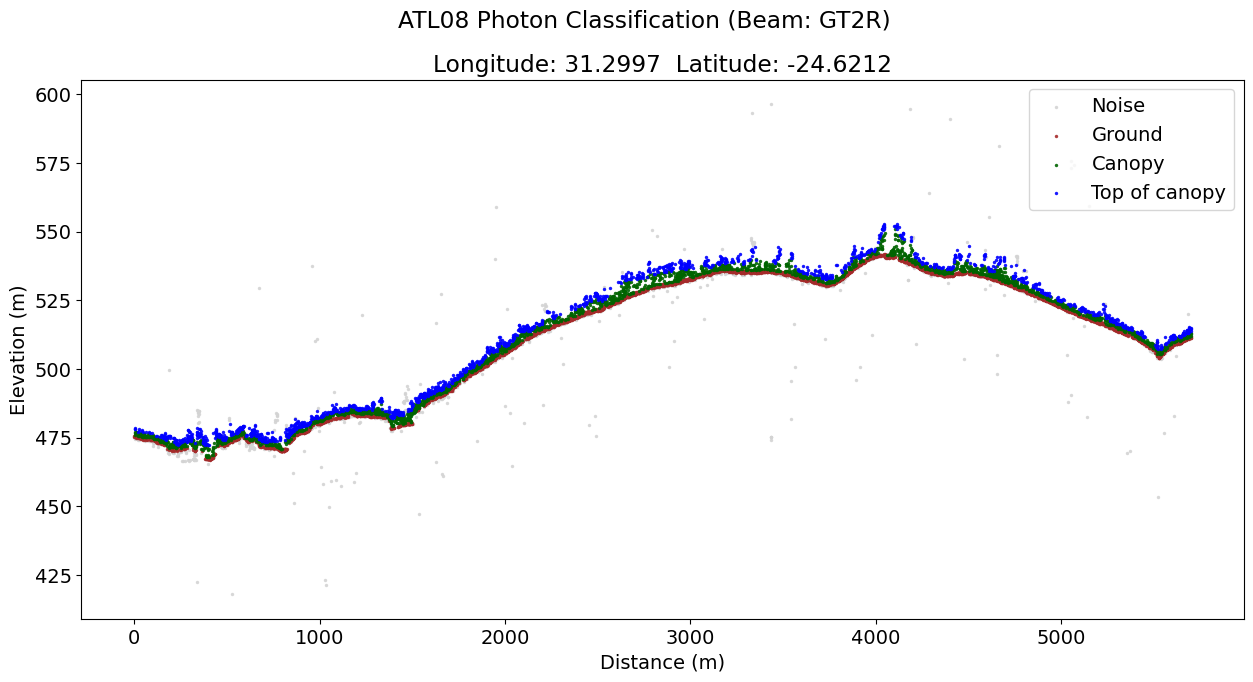

In [10]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})

class_names = ['Noise','Ground','Canopy','Top of canopy']
class_color = ['lightgrey','brown','darkgreen','blue']
start = 420000 #430000 # 1380000
transect_length = 10000
finish = min(start + transect_length, ph_class.shape[0])

def update_ph_class(start=0):
    
    finish = min(start + transect_length, ph_class.shape[0])
    fig,ax = plt.subplots(1, 1, figsize=(15, 7))

    xsub = x[start:finish]
    ysub = y[start:finish]
    dist = numpy.sqrt((xsub-xsub[0])**2 + (ysub-ysub[0])**2)
    elev = elevation[valid][start:finish]
    phcl = ph_class[valid][start:finish]
    
    for i in range( len(class_names) ):
        idx = (phcl == i)
        if numpy.count_nonzero(idx) > 0:
            ax.scatter(dist[idx], elev[idx], s=6, alpha=0.9, linewidth=0,
                       c=class_color[i], label=class_names[i])
    
    ax.legend(loc='upper right')
    
    title = 'Longitude: {:.4f}  Latitude: {:.4f}'.format(longitude[start],latitude[start])
    ax.set(title=title, xlabel='Distance (m)', ylabel='Elevation (m)')
    
    fig.suptitle('ATL08 Photon Classification (Beam: {})'.format(beam.upper()))
    fig.canvas.draw()

update_ph_class(start=start)

## Generate an interactive plot of classified photons

In [9]:
nrecords = x.shape[0]
ipywidgets.interact(update_ph_class, start=ipywidgets.IntSlider(min=0, max=nrecords-transect_length, 
                                                       step=transect_length, value=start, 
                                                       continuous_update=False))

interactive(children=(IntSlider(value=1380000, continuous_update=False, description='start', max=1950312, step…

<function __main__.update_ph_class(start=0)>

## Fit the reflectance model

In [11]:
import numpy as np
from scipy import stats
x, y = [1, 2, 3, 4, 5, 6, 7], [10, 9, 2.5, 6, 4, 3, 2]
stats.pearsonr(x, y) # [Pearson product-moment correlation coefficien, The p-value associated with the chosen alternative.]
# p< 0.05, reject null analysis. significant. 

PearsonRResult(statistic=-0.8285038835884277, pvalue=0.021280260007523352)

In [12]:
beam_name_key = {'gt1l': 1, 'gt1r': 2, 'gt2l': 3, 'gt2r': 4, 'gt3l': 5, 'gt3r': 6}
beam_id_key = {1: 'gt1l', 2:'gt1r', 3:'gt2l', 4:'gt2r', 5:'gt3l', 6:'gt3r'}

def fit_model(rv,rg):
    idx = (rv > 0) & (rg > 0)
    tmp = odr.Data(rv[idx], rg[idx])
    linear = odr.ODR(tmp, odr.unilinear, beta0=[-1.0,numpy.mean(rg[idx])])
    # rv = beta_0 * rg + beta_1
    # rv = -rhog/rhov*rv + rhog
    result = linear.run()
    rhog = result.beta[1]
    rhov = -rhog / result.beta[0]
    rhovg = -1 / result.beta[0]
    pgap = 1 - rv / (rv + rg * rhovg)
    p,p2 = stats.pearsonr(rv,rg)
    return result.beta,p,pgap,rhovg

def plot_model(rv,rg,beta,r,pgap,rhov_rhog,beam,lim=None):
    plt.rcParams.update({'font.size': 14})
    fig,ax = plt.subplots(1, 1, figsize=(10,8))
    s = ax.scatter(rv, rg, c=1-pgap, s=30, alpha=0.9, linewidth=0, vmin=0, vmax=1)
    ax.set(xlabel=r'$R_{v}$', ylabel=r'$R_{g}$', xlim=lim, ylim=lim, title=beam.upper())
    xtmp = numpy.linspace(0,lim[1],num=2)
    ax.plot(xtmp, beta[0]*xtmp + beta[1], color='black', linewidth=1)
    ax.text(1.2, 1.7, r'$\frac{\rho_v}{\rho_g}=%.02f}$'%rhov_rhog, fontsize=14)
    ax.text(1.2, 1.5, r'$r^{2}=%.02f}$'%r**2, fontsize=14)
    cbar = ax.figure.colorbar(s, ax=ax)
    cbar.ax.set_ylabel('Canopy Cover', rotation=-90, va='bottom')
    fig.canvas.draw()

In [13]:
beam_id = atl08_fid.get_data('beam')
quality = atl08_fid.get_quality_flag(night=False, power=False, 
                                     h_canopy_uncertainty=None, 
                                     n_canopy_photons=140)
rv = atl08_fid.get_data('land_segments/canopy/photon_rate_can')
rg = atl08_fid.get_data('land_segments/terrain/photon_rate_te')
seg_beg = atl08_fid.get_data('land_segments/segment_id_beg')
seg_end = atl08_fid.get_data('land_segments/segment_id_end')

In [14]:
ph_segment_id_sub = ph_segment_id[start:finish]
ph_valid = ph_segment_id_sub > 0
ph_seg_sub_min = ph_segment_id_sub[ph_valid].min()
ph_seg_sub_max = ph_segment_id_sub[ph_valid].max()
sub_idx = (seg_beg >= ph_seg_sub_min) & (seg_end <= ph_seg_sub_max) & (beam_id == beam_name_key[beam])

In [15]:
print(start, finish)

420000 430000


53 53


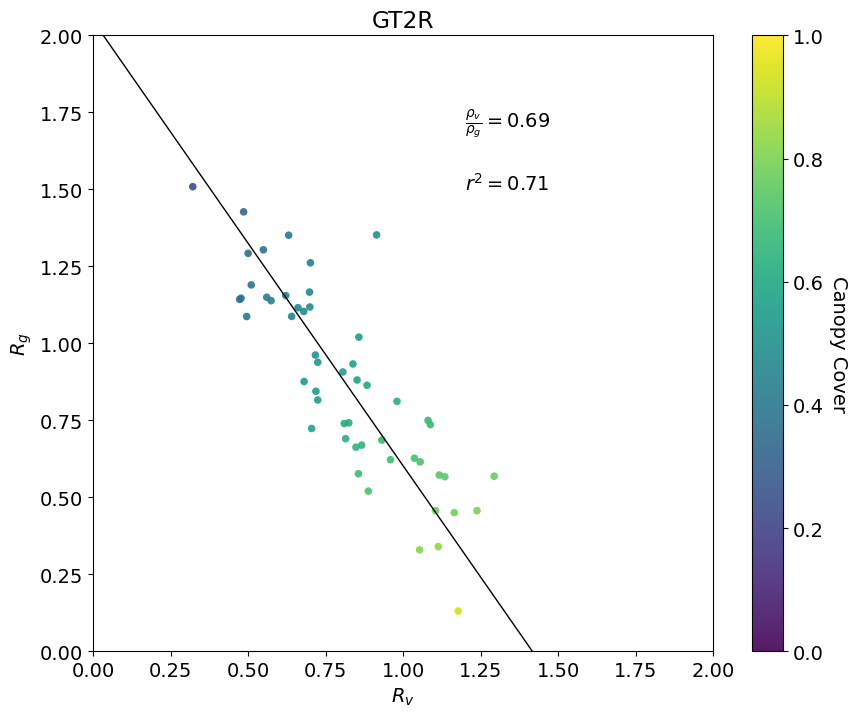

In [16]:
x = rv[sub_idx]
y = rg[sub_idx]
q = quality[sub_idx]

beta,r,pgap,rhov_rhog = fit_model(x[q],y[q])
print(len(x) , len(x[q]))
plot_model(x[q],y[q],beta,r,pgap,rhov_rhog,beam,lim=(0,2))

## Derive $R_{g}(z)$ and $R_{v}(z)$ per segment

In [17]:
@njit
def rebin_photons(ph_segment_idx, ph_height, ph_class, ph_weights,
                  min_h=0, max_h=50, hres=1):
    """Rebin photons by segment and height"""
    nsegments = int(numpy.max(ph_segment_idx) + 1)
    nbins = int((max_h - min_h) // hres)
    rg = numpy.zeros((nsegments,nbins), numpy.float32)
    rv = numpy.zeros((nsegments,nbins), numpy.float32)
    toploc = numpy.zeros(nsegments, numpy.float32)
    botloc = numpy.full(nsegments, nbins-1, numpy.float32)
    for i in range(ph_height.shape[0]):
        if ph_class[i] > 0:
            s = int(ph_segment_idx[i])
            h = int((ph_height[i] - min_h) // hres)
            if ph_class[i] == 1:
                rg[s,h] += ph_weights[i]
            elif ph_class[i] > 1:
                rv[s,h] += ph_weights[i]
            if h > toploc[s]:
                toploc[s] = h
            if h < botloc[s]:
                botloc[s] = h
    return rg,rv,toploc,botloc

In [18]:
hres = 0.5
nsegments = 10
weight = False

if weight:
    pulse,pulse_idx,pulse_cnt = numpy.unique(delta_time, return_inverse=True, return_counts=True)
    ph_weights = 1.0 / numpy.repeat(pulse_cnt, pulse_cnt)
else:
    ph_weights = numpy.ones(ph_height.shape, dtype=float)

ph_segment,ph_segment_idx,ph_segment_inv = numpy.unique(ph_segment_id // nsegments, 
                                                        return_index=True, return_inverse=True)

min_h = -1
max_h = 20
rg_z,rv_z,toploc,botloc = rebin_photons(ph_segment_inv, ph_height, ph_class, ph_weights, 
                                        min_h=min_h, max_h=max_h, hres=hres)

min_e = 440
max_e = 520
rg_z_e,rv_z_e,toploc_e,botloc_e = rebin_photons(ph_segment_inv, elevation, ph_class, ph_weights, 
                                                min_h=min_e, max_h=max_e, hres=hres)

height = numpy.arange(min_h, max_h, hres)
elev = numpy.arange(min_e, max_e, hres)
local_beam_elevation = ph_segment_id[ph_segment_idx,numpy.newaxis]

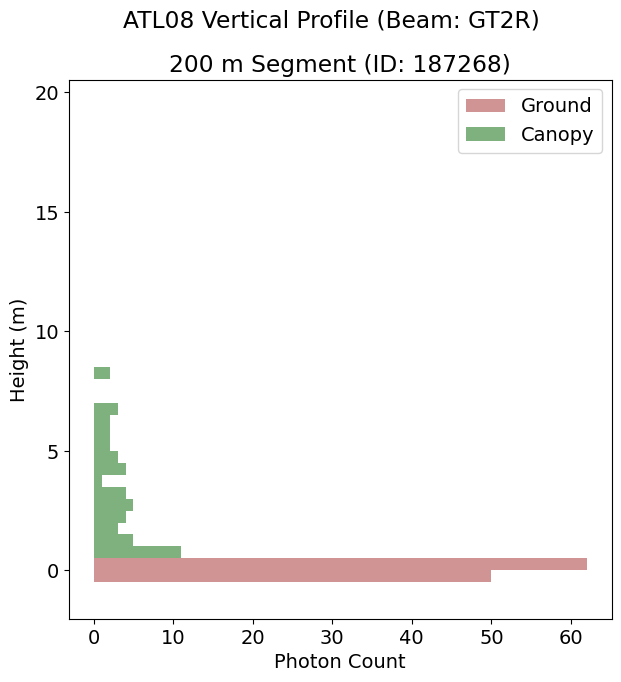

In [19]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})

class_names = ['Ground','Canopy']
class_color = ['brown','darkgreen']
profile_start = 1544

def update_profile(start=0):
    
    fig,ax = plt.subplots(1, 1, figsize=(7, 7))
    n = height.shape[0]    
    
    y = numpy.repeat(height, numpy.full(n, 2, int))
    x = numpy.roll(numpy.repeat(rg_z[start,:], numpy.full(n, 2, int)),1)
    ax.fill_betweenx(y, numpy.zeros(n*2), x, alpha=0.5,
                     facecolor=class_color[0], label=class_names[0])    
    
    y = numpy.repeat(height, numpy.full(n, 2, int))
    x = numpy.roll(numpy.repeat(rv_z[start,:], numpy.full(n, 2, int)),1)    
    ax.fill_betweenx(y, numpy.zeros(n*2), x, alpha=0.5,
                     facecolor=class_color[1], label=class_names[1])    
    
    ax.legend(loc='upper right')    
    ax.set(title=f'{nsegments*20:d} m Segment (ID: {ph_segment[start]:d})', 
           xlabel='Photon Count', ylabel='Height (m)')    
    
    fig.suptitle(f'ATL08 Vertical Profile (Beam: {beam.upper()})')
    fig.canvas.draw()

update_profile(start=profile_start)

In [21]:
nrecords_profile = ph_segment.shape[0]
ipywidgets.interact(update_profile, start=ipywidgets.IntSlider(min=0, max=nrecords_profile-1, 
                    step=1, value=profile_start, continuous_update=False))

interactive(children=(IntSlider(value=1544, continuous_update=False, description='start', max=11006), Output()…

<function __main__.update_profile(start=0)>

## Calculate canopy cover and PAVD

For the nadir view of ICESat-2 we can ignore the impact of $\theta_{inc}$ but we included here for completeness

In [22]:
def get_pgap_theta_z(rv_z, rg_z, rhov_rhog):
    rv_z_cum = numpy.cumsum(rv_z[:,::-1], axis=1)
    rv = rv_z.sum(axis=1, keepdims=True)
    rg = rg_z.sum(axis=1, keepdims=True)
    pgap_theta_z = 1 - rv_z_cum / (rv + rg * rhov_rhog)
    return pgap_theta_z[:,::-1]

def get_cover_metrics(pgap_theta_z, height, local_beam_elevation, 
                      rossg=0.5, omega=1.0):
    cos_zenith = numpy.abs( numpy.sin(local_beam_elevation) )
    cover_z = cos_zenith * (1.0 - pgap_theta_z)
    pai_z = -(1.0 / (rossg * omega)) * numpy.log(pgap_theta_z) * cos_zenith 
    pavd_z = -numpy.gradient(pai_z, height, axis=1)       
    return cover_z, pai_z, pavd_z

def get_rh_metrics(rv_z, rg_z, height, toploc, botloc):
    rx = rv_z + rg_z
    x = numpy.arange(0,1.01,0.01)
    rh = numpy.zeros((rv_z.shape[0],101), dtype=float)
    for i in range(rx.shape[0]):
        if botloc[i] < toploc[i]:
            start = int(botloc[i])
            end = int(toploc[i] + 1)
            rx_tmp = rx[i,start:end]
            ht_tmp = height[start:end]
            rx_cum = numpy.cumsum(rx_tmp)
            xp = rx_cum / rx_cum[-1]
            rh[i,:] = numpy.interp(x, xp, ht_tmp)
    return rh

In [23]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    pgap_theta_z = get_pgap_theta_z(rv_z, rg_z, rhov_rhog)
    cover_z, pai_z, pavd_z = get_cover_metrics(pgap_theta_z, height, local_beam_elevation)
    rh = get_rh_metrics(rv_z, rg_z, height, toploc, botloc)

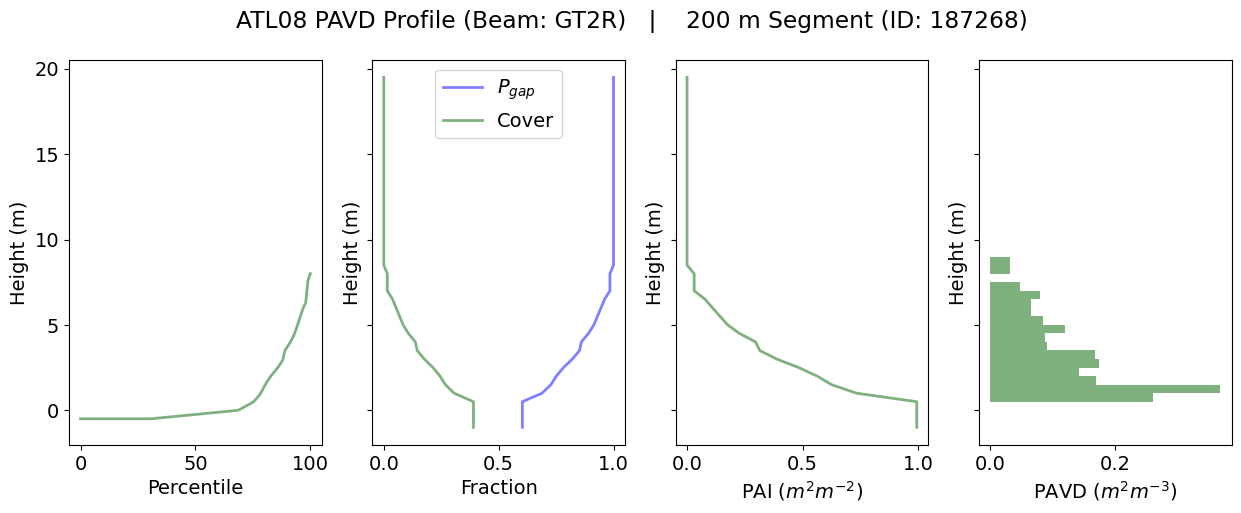

In [24]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})

pavd_start = 1544

def update_pavd(start=0):
    
    fig,ax = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    n = height.shape[0]    

    x = numpy.arange(0,101,1)
    ax[0].plot(x, rh[start,:], alpha=0.5, color='darkgreen', linewidth=2)
    ax[0].set(xlabel='Percentile', ylabel='Height (m)', xlim=(-5,105))    

    ax[1].plot(pgap_theta_z[start,:], height, alpha=0.5, color='blue', linewidth=2, label=r'$P_{gap}$')
    ax[1].plot(cover_z[start,:], height, alpha=0.5, color='darkgreen', linewidth=2, label='Cover')
    ax[1].set(xlabel='Fraction', ylabel='Height (m)', xlim=(-0.05,1.05))
    ax[1].legend()

    ax[2].plot(pai_z[start,:], height, alpha=0.5, color='darkgreen', linewidth=2)
    ax[2].set(xlabel=r'PAI ($m^{2}m^{-2}$)', ylabel='Height (m)', ylim=(None,None))     
    
    y = numpy.repeat(height, numpy.full(n, 2, int))
    x = numpy.roll(numpy.repeat(pavd_z[start,:], numpy.full(n, 2, int)),1)
    ax[3].fill_betweenx(y, numpy.zeros(n*2), x, alpha=0.5, facecolor='darkgreen')    
    ax[3].set(xlabel=r'PAVD ($m^{2}m^{-3}$)', ylabel='Height (m)')    
    
    fig.suptitle(f'ATL08 PAVD Profile (Beam: {beam.upper()})   |\
    {nsegments*20:d} m Segment (ID: {ph_segment[start]:d})')
    fig.canvas.draw()

update_pavd(start=pavd_start)

In [25]:
nrecords_pavd = ph_segment.shape[0]
ipywidgets.interact(update_pavd, start=ipywidgets.IntSlider(min=0, max=nrecords_pavd-1, 
                    step=1, value=pavd_start, continuous_update=False))

interactive(children=(IntSlider(value=1544, continuous_update=False, description='start', max=11006), Output()…

<function __main__.update_pavd(start=0)>

In [26]:
atl03_fid.close_h5()
atl08_fid.close_h5()

In [ ]:
# my step: Can i get this for all cal/val database